# Comparison of Bayesian Optimization to Random Search for a NN regressor


In [0]:
#!pip install ipython-autotime
#to time the cell runs
%load_ext autotime

This experiment uses an MLP regressor with variable hyperparameters, and selects these hyperparameters using these two methods. The metric of performance is negative RMSE, and the goal is to compare the methods rather than obtain a neural network that is very performant.

For the Bayesian optimization algorithm, the GP regressor (surrogate function) is parameterized according to the constant mean function and Matern kernel with varying *$\nu$* scale parameter. The values of this *$\nu$* are reported in the appendix.

In [0]:
!pip install GPy

In [0]:
!pip install GPyOpt

In [0]:
!pip install python-intervals

Import the necessary modules and prepare the *diabetes dataset*.

In [0]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score #run grid search on hyperparameters as well
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization
from scipy.stats import uniform
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)
#print(Y) #integer targets
scaler = StandardScaler()
#data is scaled before being fed into the neural network. Not the targets though
X_scaled = scaler.fit_transform(X)

# Instantiate a MLP with default setup. This will be modified later
mlp = MLPRegressor()


First, random search on a pre-defined 'input space' of the hyperparameters.

Note: Since the optimizer is Adam, the learning rate is constant and thus does not incorporate a schedule. ReLu activations are used by default in the hidden layers, and identity function in the output layer (where the regression happens).

In [0]:
#alpha is the L2 regularization parameter, default for which 0.0001. This is generally left small, so a tight interval is considered.
#learning rate of adam gradient-based optimizer. This has a default value of 0.001 and is left constant with Adam optimizer.


alpha_schedule = np.array([0.0001, 0.0005, 0.001]) #three values, all quite small as overfitting is not exactly a concern
learning_rate_schedule = np.array([0.001, 0.005, 0.1]) #three values, reasonable magnitudes

#dimension of input is 10. The network architecture consists of 2-tuples, where (20,10) 
#means 20 neurons in the first hidden layer and 10 before the final (identity) activation. 2 LAYERS

from itertools import product 
max_layer_size = 50
N_layers = 2
arch = [ele for ele in product(range(1, max_layer_size + 1), repeat = N_layers)] 

#keep architectures where layer1 >= layer2
architectures = [(a, b) for a, b in arch if (a >= b)] 



# Random search...

In [0]:
import warnings
import time
from random import seed
from random import randint
from itertools import product 
seed(1)

warnings.filterwarnings("ignore") 
# Hyperparameters to tune and their ranges. For now a single layer NN... to accomodate the Bayesian optimization 
mlp_param_dist = {"alpha": uniform(0, 0.001),
                  "hidden_layer_sizes": range(10,50),
                  "batch_size": range(32,64),
                  "learning_rate_init": uniform(0, 0.01)} 
                  
#25 iterations
rs = RandomizedSearchCV(mlp, param_distributions=mlp_param_dist, 
                        scoring='neg_mean_squared_error', n_iter=30)
# Run random search for 25 iterations
rs.fit(X_scaled, Y);



time: 1min


Performance of random search, along with reported hyperparameters.

In [0]:
print(rs.best_params_)
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score']) 
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')

{'alpha': 0.0008889915893842183, 'batch_size': 63, 'hidden_layer_sizes': 30, 'learning_rate_init': 0.008268865599049404}
Random search neg. MSE = -2963.25
time: 2.55 ms


# ...Bayesian optimization

In [0]:
mlp_bds = [{'name': 'alpha', 'type': 'continuous', 'domain': (0,0.01)},
           {'name': 'hidden_layer_sizes', 'type': 'discrete', 'domain': tuple(range(10, 50))},
           {'name': 'batch_size', 'type': 'discrete', 'domain': tuple(range(32,64))},
           {'name': 'learning_rate_init', 'type': 'continuous', 'domain': (0,0.01)}]

#adam optimizer used by default, left as is.

# Optimization objective 
def cv_score(parameters): #how many cv folds? default is 5
    parameters = parameters[0]
    score = cross_val_score(
                MLPRegressor(alpha = parameters[0], hidden_layer_sizes = int(parameters[1]), batch_size = int(parameters[2]), learning_rate_init = parameters[3]), 
                              X_scaled, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.5) #vary the nu parameter and comment. How does nu behave in terms of smoothness?
optimizer = BayesianOptimization(f=cv_score, 
                                 domain=mlp_bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI', #'MPI', 'LCB'/'UCB' in the case of maximization
                                 acquisition_jitter = 0.01, #xi
                                 exact_feval=True, 
                                 maximize=True)

#25 iterations
optimizer.run_optimization(max_iter=25)
%time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
time: 1min 7s


Reported hyperparameters according to Bayesian Optimization

In [0]:
optimal_alpha = np.round(optimizer.x_opt[0],4)
optimal_hidden_layer_size = int(optimizer.x_opt[1])
optimal_batch_size = int(optimizer.x_opt[2])
optimal_lr = np.round(optimizer.x_opt[3],4)
print(optimal_alpha, optimal_hidden_layer_size, optimal_batch_size, optimal_lr)

0.0083 19 54 0.0088
time: 5.69 ms


# Comparison:

Random search neg. MSE = -2963.25
Bayesian optimization neg. MSE = -2939.24


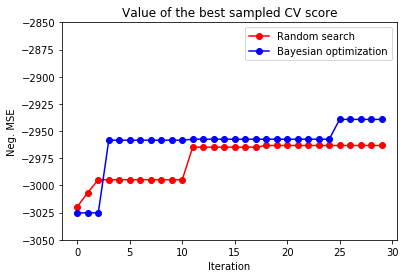

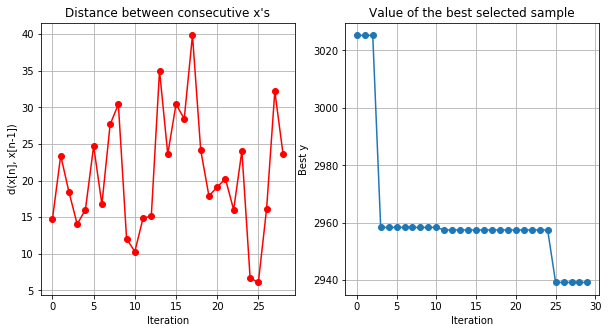

time: 473 ms


In [0]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score']) #are there other performance measures?
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
#y_gs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])

print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
#print(f'Grid search neg. MSE = {y_gs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')


plt.plot(y_rs, 'ro-', label='Random search')
#plt.plot(y_gs, label='Grid search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-3050, -2850)
plt.title('Value of the best sampled CV score');
plt.legend();
optimizer.plot_convergence()

#is there a way to incorporate Bayesian uncertainty into this plot?
#optimizer.plot_regret()

Note that in this problem, we do not have consistent results. The problem is that the network is not trained well enough on the data, and so its poor performance may be a confounding factor.

The idea I've had is thus to train a network beforehand, so as to make it perform well on the data, then 'budge' its hyperparameters (by considering domain spaces that are tight and include the pre-selected hyperparameters) to see if we can improve its performance. Both random search and Bayesian optimization can be used to that end, to see which will perform better in improving an already-good model.